In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install datasets
%pip install transformers
%pip install accelerate
!pip install accelerate -U
!pip install transformers[torch] -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 4.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none

In [3]:
import os

# Define the directory where the patent files are stored
patent_dir = '/content/drive/MyDrive/AllPatentTextDocs'

# Read the content of each patent file
patents = {}
for filename in os.listdir(patent_dir):
    if filename.endswith('.txt'):
        with open(os.path.join(patent_dir, filename), 'r') as file:
            patents[filename] = file.read()


In [7]:
import os
import re
import random
from typing import Dict, List, Tuple

# Define a function to extract the required information from the patent text
def preprocess_patent(file_content: str) -> Dict[str, str]:
    # Extract the fields using regular expressions
    patent_number_match = re.search(r"Patent Number: ([^\n]+)", file_content)
    link_match = re.search(r"PDF Link: ([^\n]+)", file_content)
    abstract_match = re.search(r"Abstract: ([^\n]+)", file_content)
    classifications_match = re.search(r"Classifications: \{([^\}]+)\}", file_content)

    # Clean up and structure the document excluding the abstract, patent number, pdf link, and classifications
    excluded_sections = ['Abstract', 'Patent Number', 'PDF Link', 'Classifications']
    source_document = file_content
    for section in excluded_sections:
        source_document = re.sub(f"{section}: [^\n]+\n", "", source_document)

    # Remove extra whitespace and join the text
    source_document = ' '.join(source_document.split())

    return {
        'patent_id': patent_number_match.group(1).strip() if patent_number_match else '',
        'link': link_match.group(1).strip() if link_match else '',
        'X': source_document.strip(),
        'Y_ref': abstract_match.group(1).strip() if abstract_match else '',
        'classifications': classifications_match.group(1).strip() if classifications_match else ''
    }

# Function to randomly split the dataset into training and testing
def split_data(dataset: List[Dict[str, str]], train_ratio: float = 0.8) -> Tuple[List[Dict[str, str]], List[Dict[str, str]]]:
    random.shuffle(dataset)
    train_size = int(len(dataset) * train_ratio)
    train_set, test_set = dataset[:train_size], dataset[train_size:]
    return train_set, test_set

# Path to the directory containing patent text files
patent_dir = '/content/drive/My Drive/AllPatentTextDocs'

# List all text files in the directory
patent_files = [file for file in os.listdir(patent_dir) if file.endswith('.txt')]

# Process each file and collect the data
all_patent_data = []
for patent_file in patent_files:
    file_path = os.path.join(patent_dir, patent_file)
    with open(file_path, 'r', encoding='utf-8') as file:
        file_content = file.read()
        patent_data = preprocess_patent(file_content)
        all_patent_data.append(patent_data)

# Split the data into train and test sets
train_set, test_set = split_data(all_patent_data)

# Output the size of each set to verify
print(f"Total patents: {len(all_patent_data)}")
print(f"Training set size: {len(train_set)}")
print(f"Testing set size: {len(test_set)}")


Total patents: 1630
Training set size: 1304
Testing set size: 326


In [8]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset, load_metric
import numpy as np

# Initialize the tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Function to tokenize the input and the summary
def tokenize_function(examples):
    # Tokenize the texts and include padding to the maximum length
    model_inputs = tokenizer(examples["text"], max_length=512, truncation=True, padding="max_length")
    # Tokenize the summaries (targets) and include padding
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=128, truncation=True, padding="max_length")
    # 'labels' is a list of lists, where each sublist is the tokenized version of a summary
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Assuming 'train_set' and 'test_set' are lists of dictionaries containing the fields 'X' and 'Y_ref'
train_dataset = Dataset.from_dict({
    'text': [example['X'] for example in train_set],
    'summary': [example['Y_ref'] for example in train_set]
})
test_dataset = Dataset.from_dict({
    'text': [example['X'] for example in test_set],
    'summary': [example['Y_ref'] for example in test_set]
})

# Apply the tokenization to the datasets
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Load the model
model = T5ForConditionalGeneration.from_pretrained('t5-small')

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer
)

# Train the model
trainer.train()

# Save the model
model.save_pretrained('./my_t5_model')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/1304 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3921: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/326 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss
1,2.554300,2.385702
2,2.094400,1.969130
3,1.816700,1.833651


In [9]:

model.save_pretrained('./my_t5_model')
tokenizer.save_pretrained('./my_t5_model')


('./my_t5_model/tokenizer_config.json',
 './my_t5_model/special_tokens_map.json',
 './my_t5_model/spiece.model',
 './my_t5_model/added_tokens.json')

In [10]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from datasets import load_dataset, load_metric

# Load the trained model and tokenizer
model_path = './my_t5_model'
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)

# Function to generate summaries on the test set
def generate_summaries(test_data):
    summaries = []
    for example in test_data:
        # Encode the text input to be compatible with the model
        inputs = tokenizer.encode("summarize: " + example["X"], return_tensors="pt", max_length=512, truncation=True)
        # Generate summary with the model
        outputs = model.generate(inputs, max_length=150, length_penalty=2.0, num_beams=4, early_stopping=True)
        # Decode the generated ids to text
        summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
        summaries.append(summary)
    return summaries

# containing the 'X' key for text and 'Y_ref' for the ground truth summary
generated_summaries = generate_summaries(test_set)
reference_summaries = [example["Y_ref"] for example in test_set]



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=2f2dfde95328544b119ecbc0edc38eb35b97b17f1941526283f63a5f16abe4f4
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [13]:
from datasets import load_metric

# Load the rouge metric
rouge = load_metric("rouge", trust_remote_code=True)

# Calculate ROUGE scores
results = rouge.compute(predictions=generated_summaries, references=reference_summaries)

# Check if results are not empty and print the scores
if results:
    for key, score in results.items():
        # The score here is an AggregateScore object, which contains a 'mid' named tuple
        mid_scores = score.mid
        print(f"{key}:")
        print(f"  Precision: {mid_scores.precision:.4f}")
        print(f"  Recall: {mid_scores.recall:.4f}")
        print(f"  F1: {mid_scores.fmeasure:.4f}\n")
else:
    print("No results to display.")

# Add generated summaries back to test_set for potential further analysis
for i, summary in enumerate(generated_summaries):
    test_set[i]['generated_summary'] = summary


rouge1:
  Precision: 0.6128
  Recall: 0.4967
  F1: 0.5276

rouge2:
  Precision: 0.3914
  Recall: 0.3190
  F1: 0.3377

rougeL:
  Precision: 0.4778
  Recall: 0.3897
  F1: 0.4123

rougeLsum:
  Precision: 0.4783
  Recall: 0.3896
  F1: 0.4127



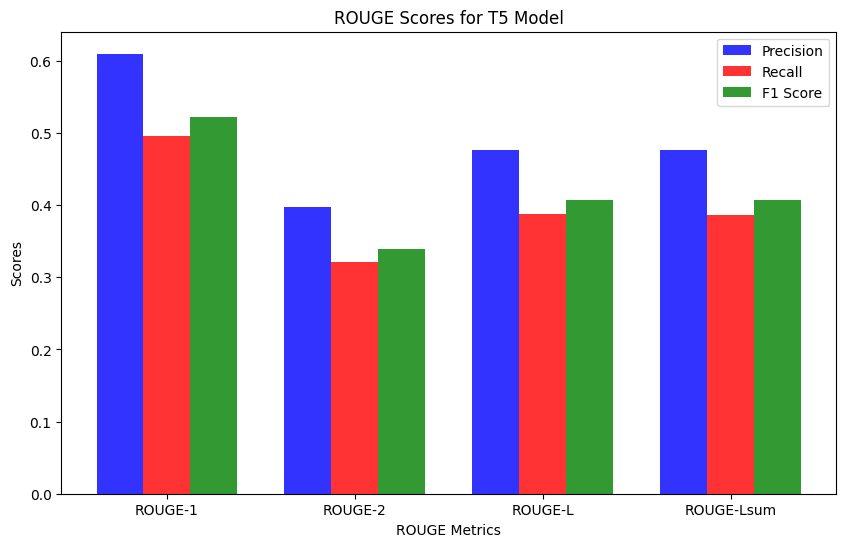

In [14]:
import matplotlib.pyplot as plt

# Defining the data for the ROUGE scores
rouge_types = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'ROUGE-Lsum']
precision = [0.6097, 0.3971, 0.4759, 0.4758]
recall = [0.4954, 0.3213, 0.3872, 0.3868]
f1 = [0.5220, 0.3392, 0.4076, 0.4075]

# Creating a plot
fig, ax = plt.subplots(figsize=(10, 6))

# Index for the groups
index = range(len(rouge_types))

# Bar width
bar_width = 0.25

# Transparency setting
opacity = 0.8

# Creating bars
rects1 = ax.bar(index, precision, bar_width, alpha=opacity, color='b', label='Precision')
rects2 = ax.bar([p + bar_width for p in index], recall, bar_width, alpha=opacity, color='r', label='Recall')
rects3 = ax.bar([p + bar_width * 2 for p in index], f1, bar_width, alpha=opacity, color='g', label='F1 Score')

# Adding labels, title, and legend
ax.set_xlabel('ROUGE Metrics')
ax.set_ylabel('Scores')
ax.set_title('ROUGE Scores for T5 Model')
ax.set_xticks([p + bar_width for p in index])
ax.set_xticklabels(rouge_types)
ax.legend()

# Show the plot
plt.show()